In [1]:
# Library imports
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pennylane as qml

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

/Users/tobykrieman/anaconda/envs/qc-penny/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# dataloader
class DigitsDataset(Dataset):
    """Pytorch dataloader for the Optical Recognition of Handwritten Digits Data Set"""

    def __init__(self, csv_file, label=0, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv_file = csv_file
        self.transform = transform
        self.df = self.filter_by_label(label)

    def filter_by_label(self, label):
        # Use pandas to return a dataframe of only zeros
        df = pd.read_csv(self.csv_file)
        df = df.loc[df.iloc[:, -1] == label]
        return df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.df.iloc[idx, :-1] / 16
        image = np.array(image)
        image = image.astype(np.float32).reshape(8, 8)

        if self.transform:
            image = self.transform(image)

        # Return image and label
        return image, 0

In [3]:
image_size = 8  # Height / width of the square images
batch_size = 1

transform = transforms.Compose([transforms.ToTensor()])
dataset = DigitsDataset(csv_file="optdigits.tra", transform=transform, label=0) # working only with 0
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True, drop_last=True
)

In [70]:
data = np.load("full_numpy_bitmap_flamingo.npy")
data.shape

(124569, 784)

In [75]:
import cv2

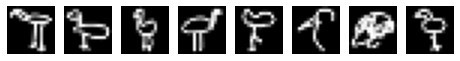

In [80]:
plt.figure(figsize=(8,2))

for i in range(8):
    image = data[i+1000].reshape(28,28)
    image = cv2.resize(image, dsize=(16, 16), interpolation=cv2.INTER_CUBIC)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image, cmap='gray')

plt.show()

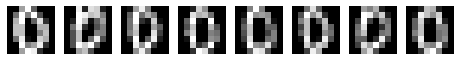

In [4]:
plt.figure(figsize=(8,2))

for i in range(8):
    image = dataset[i][0].reshape(image_size,image_size)
    plt.subplot(1,8,i+1)
    plt.axis('off')
    plt.imshow(image.numpy(), cmap='gray')

plt.show()


In [45]:
# classical discriminator
class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(image_size * image_size, 64),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            #nn.Linear(64, 16),
            #nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

In [81]:
# Quantum variables
n_qubits = 5  # Total number of qubits = N
nq_full = 10
n_a_qubits = 1  # Number of ancillary qubits = N_A
q_depth = 10  # Depth of the parameterised quantum circuit = D
n_generators = 16  # Number of subgenerators for the patch method = N_G

In [47]:
# Quantum simulator
dev = qml.device("lightning.qubit", wires=nq_full)
# Enable CUDA device if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [48]:
# generator circuit
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit(noise, weights):

    weights = weights.reshape(q_depth, n_qubits)

    qml.Hadamard(wires=0)
    qml.CNOT(wires=[0, 4])
    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)

    
    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(n_qubits)))

In [49]:
# Non linearity to output of generator
# For further info on how the non-linear transform is implemented in Pennylane
# https://discuss.pennylane.ai/t/ancillary-subsystem-measurement-then-trace-out/1532
def partial_measure(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit(noise, weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

def nonlinearity(noise, weights):
    
    probs = quantum_circuit(noise, weights)
    first = probs[: (2 ** (n_qubits - n_a_qubits))]
    second = probs[(2 ** (n_qubits - n_a_qubits)):]
    return torch.sigmoid(first + second)
    

In [50]:
class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, n_generators, q_delta=1, do_partial_measure=True):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.do_partial_measure = do_partial_measure

        # weights for generator in quantum circuit
        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (n_qubits - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        # Iterate over all sub-generators
        for params in self.q_params:

            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                # run generator circuit
                if self.do_partial_measure:
                    q_out = partial_measure(elem, params).float().unsqueeze(0)
                else:
                    q_out = nonlinearity(elem, params).float().unsqueeze(0)
                patches = torch.cat((patches, q_out))

            # Each batch of patches is concatenated with each other to create a batch of images
            images = torch.cat((images, patches), 1)

        return images


In [51]:
class FullGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self, q_delta=1, do_partial_measure=True):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.do_partial_measure = do_partial_measure

        # weights for generator in quantum circuit
        self.q_params = nn.Parameter(q_delta * torch.rand(q_depth * nq_full), requires_grad=True)
            

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** (nq_full - n_a_qubits)

        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        images = torch.Tensor(x.size(0), 0).to(device)

        

        # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
        patch = torch.Tensor(0, patch_size).to(device)
        for elem in x:
            # run generator circuit
            if self.do_partial_measure:
                q_out = partial_measure_full(elem, self.q_params).float().unsqueeze(0)
            else:
                q_out = nonlinearity(elem, self.q_params).float().unsqueeze(0)
            patch = torch.cat((patch, q_out))

        # Each batch of patches is concatenated with each other to create a batch of images
        images = torch.cat((images, patch), 1)

        return images


In [52]:
# generator circuit
@qml.qnode(dev, interface="torch", diff_method="parameter-shift")
def quantum_circuit_full(noise, weights):

    weights = weights.reshape(q_depth, nq_full)

    
    # Initialise latent vectors
    for i in range(nq_full):
        qml.RY(noise[i], wires=i)

    
    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(nq_full):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(nq_full - 1):
            qml.CZ(wires=[y, y + 1])

    return qml.probs(wires=list(range(nq_full)))


def partial_measure_full(noise, weights):
    # Non-linear Transform
    probs = quantum_circuit_full(noise, weights)
    probsgiven0 = probs[: (2 ** (nq_full - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    # Post-Processing
    probsgiven = probsgiven0 / torch.max(probsgiven0)
    return probsgiven

In [53]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 400  # Number of training iterations

In [54]:
# training 

discriminator = Discriminator().to(device)
#generator = PatchQuantumGenerator(n_generators, do_partial_measure=False).to(device)
generator = FullGenerator().to(device)

# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((batch_size,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((batch_size,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(8, nq_full, device=device) * math.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
results = []

while True:
    for i, (data, _) in enumerate(dataloader):

        # Data for training the discriminator
        data = data.reshape(-1, image_size * image_size)
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(batch_size, nq_full, device=device) * math.pi / 2
        fake_data = generator(noise)

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        optD.step()

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        errG.backward()
        optG.step()

        counter += 1

        # Show loss values
        if counter % 10 == 0:
            print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
            test_images = generator(fixed_noise).view(8,1,image_size,image_size).cpu().detach()

            # Save images every 50 iterations
            if counter % 50 == 0:
                results.append(test_images)

        if counter == num_iter:
            break
    if counter == num_iter:
        break

Iteration: 10, Discriminator Loss: 1.334, Generator Loss: 0.638
Iteration: 20, Discriminator Loss: 1.282, Generator Loss: 0.641
Iteration: 30, Discriminator Loss: 1.240, Generator Loss: 0.647
Iteration: 40, Discriminator Loss: 1.273, Generator Loss: 0.595
Iteration: 50, Discriminator Loss: 1.137, Generator Loss: 0.634
Iteration: 60, Discriminator Loss: 1.066, Generator Loss: 0.681
Iteration: 70, Discriminator Loss: 1.082, Generator Loss: 0.677
Iteration: 80, Discriminator Loss: 1.052, Generator Loss: 0.655
Iteration: 90, Discriminator Loss: 1.095, Generator Loss: 0.638
Iteration: 100, Discriminator Loss: 1.252, Generator Loss: 0.522
Iteration: 110, Discriminator Loss: 1.116, Generator Loss: 0.637
Iteration: 120, Discriminator Loss: 1.181, Generator Loss: 0.569
Iteration: 130, Discriminator Loss: 1.015, Generator Loss: 0.665
Iteration: 140, Discriminator Loss: 1.123, Generator Loss: 0.574
Iteration: 150, Discriminator Loss: 0.910, Generator Loss: 0.758
Iteration: 160, Discriminator Loss

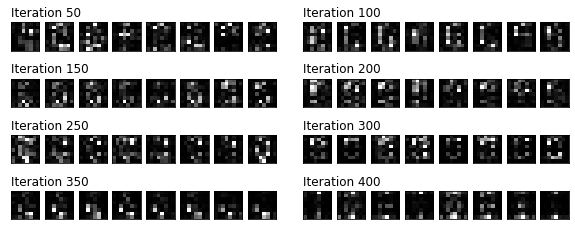

In [55]:
fig = plt.figure(figsize=(10, 5))
outer = gridspec.GridSpec(5, 2, wspace=0.1)

for i, images in enumerate(results):
    inner = gridspec.GridSpecFromSubplotSpec(1, images.size(0),
                    subplot_spec=outer[i])

    images = torch.squeeze(images, dim=1)
    for j, im in enumerate(images):

        ax = plt.Subplot(fig, inner[j])
        ax.imshow(im.numpy(), cmap="gray")
        ax.set_xticks([])
        ax.set_yticks([])
        if j==0:
            ax.set_title(f'Iteration {50+i*50}', loc='left')
        fig.add_subplot(ax)

plt.show()